### Importing All Necessary Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from matplotlib.widgets import Cursor
from scipy.stats import randint
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler


### Dataframe Creation  <br>

html_to_df(): Converting all 'Excel' files that turned out to be in HTML format into a single combined pandas dataframe for simpler data manipulation <br>

### Data Cleaning <br>

Cleaned up first two row layout of dataframe since scrapped HTML data put headers into two rows <br>
Renamed columns to give better clarity <br>
Deconstructed Results Column that Outputted Value like "W 24-10" to isolate the scores and calculate the score differential to determine team's win or loss <br>
Split Date Column into 'Year' and 'Month-Day' <br>
Dropped Unecessary Columns in Dataframe <br>
Simplified Age Column Through Only Keeping Year and Dropping Days <br>
Handled Null Values and Validated Data Types <br>
Utilized Pandas Get Dummies One Hot Encoding to Transform Home_Away_Determinant & Day Features



Print statements to evaluate the data better <br><br>

In [3]:


def html_to_df(path):
    weekly_rb_stats = []
    htmlFiles = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".xlsx")]
    for file in htmlFiles:
        try:
            df = pd.read_html(file,header=[0,1])[0]
            weekly_rb_stats.append(df)
        except ValueError:
            print(f"No valid tables found in {file}")
        except Exception as e:
            print(f"Error processing file: {e}")
    weekly_rb_stats = pd.concat(weekly_rb_stats)
    return weekly_rb_stats
    

download_dir = os.path.join(os.getcwd(), "selenium_downloads")
weekly_stats_df = html_to_df(download_dir)
## Print statements inspecting dataframe
#print(f"Preview of Weekly RB Stats: {weekly_stats_df.head()}")
#print(f"\n Statistical Summary of Weekly RB Stats: {weekly_stats_df.describe()}")
#print(f"\n Size of Weekly RB Stats Dataframe: {weekly_stats_df.shape}")


#Cleaning up Column Names
newColumns = []
for column in weekly_stats_df.columns:
    if isinstance(column,tuple) and column[0].startswith('Unnamed'):
        newColumns.append(column[1])
    elif isinstance(column, tuple):
        newColumns.append(column[0] + '_' + column[1])
    else:
        newColumns.append(column)
weekly_stats_df.columns = newColumns

#Renaming Columns for better transparency
weekly_stats_df.rename(columns={'Unnamed: 10_level_1':'Home_Away_Determinant','FantPt':'Fantasy_Pts', 
                                'Att':'Rushing_Att','Rushing_Y/A':'Rushing_YPC',
                                'G#':'Game_Number','Rushing_1D':'Rushing_FirstDown'}, inplace=True)

#Breaking Down Results Column To Simplify Analysis
weekly_stats_df[['Victory_Status', 'Score']] = weekly_stats_df['Result'].str.split(' ', n=1, expand=True)
weekly_stats_df[['Team_Pts', 'Opp_Pts']] = weekly_stats_df['Score'].str.split('-', n=1, expand=True)
weekly_stats_df['Team_Pts'] = weekly_stats_df['Team_Pts'].astype(int)
weekly_stats_df['Opp_Pts'] = weekly_stats_df['Opp_Pts'].str.extract(r'(\d+)').astype(int)
weekly_stats_df['Score_Diff'] = weekly_stats_df['Team_Pts'] - weekly_stats_df['Opp_Pts'] #Negative values indicate a loss

#Splitting the 'Date' column into 'Year' and 'Month-Day'
weekly_stats_df['Year'] = weekly_stats_df['Date'].str.split('-').str[0]
weekly_stats_df['Year'] = weekly_stats_df['Year'].astype(int)  
weekly_stats_df['Month_Day'] = weekly_stats_df['Date'].str.split('-').str[1] + '-' + weekly_stats_df['Date'].str.split('-').str[2]


#Evaluating Unique Values in All Columns in DataFrame
unique_values = weekly_stats_df.nunique()
#print(f"Unique values in each column:\n{unique_values}")

#Dropping Unecessary Columns
weekly_stats_df_clean = weekly_stats_df.drop(columns=['Pos.','Dayâ¼','Rk', 'Result', 'Score', 'Victory_Status', 'Date'])

#Keeping only first occurrence of Duplicated Column
weekly_stats_df_clean = weekly_stats_df_clean.loc[:, ~weekly_stats_df_clean.columns.duplicated()]
#Simplifying Age Column
weekly_stats_df_clean['Age'] = weekly_stats_df_clean['Age'].str.split('-').str[0] #Only including year for age
weekly_stats_df_clean['Age'] = weekly_stats_df_clean['Age'].astype(int) #Making age column as integer

nullColumns = weekly_stats_df_clean.isna().any()
#print(f"Null Columns in dataframe: {nullColumns}")
#Handling Null Values
weekly_stats_df_clean['Home_Away_Determinant'] = weekly_stats_df_clean['Home_Away_Determinant'].fillna('vs')
weekly_stats_df_clean['Rushing_FirstDown'] = weekly_stats_df_clean['Rushing_FirstDown'].fillna(0.0)
weekly_stats_df_clean['Day'] = weekly_stats_df_clean['Day'].fillna('Sun') #Assuming no date recorded is Sunday game for simplicity

#Validating Data Types
weekly_stats_df_clean['Week'] = weekly_stats_df_clean['Week'].astype(int)
weekly_stats_df_clean['Game_Number'] = weekly_stats_df_clean['Game_Number'].astype(int)

#Encoding Home/Away Determinant, & GameDay Features
homeAway_enc = pd.get_dummies(weekly_stats_df_clean['Home_Away_Determinant'], drop_first=True).astype(int)
weekly_stats_df_clean_enc = pd.concat([weekly_stats_df_clean, homeAway_enc], axis=1)
weekly_stats_df_clean_enc = weekly_stats_df_clean_enc.drop(columns=['Home_Away_Determinant'])
weekly_stats_df_clean_enc = weekly_stats_df_clean_enc.rename(columns={'vs':'Home_Away_Determinant'})


#Encoding Day Feature
day_encoding = pd.get_dummies(weekly_stats_df_clean_enc['Day'], prefix='GameDay', drop_first=True).astype(int)
weekly_stats_df_clean_enc = pd.concat([weekly_stats_df_clean_enc, day_encoding], axis=1)
weekly_stats_df_clean_enc = weekly_stats_df_clean_enc.drop(columns=['Day'])


weekly_stats_df_clean_enc.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14200 entries, 0 to 199
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 14200 non-null  object 
 1   Fantasy_Pts            14200 non-null  float64
 2   Rushing_Att            14200 non-null  int64  
 3   Game_Number            14200 non-null  int64  
 4   Week                   14200 non-null  int64  
 5   Age                    14200 non-null  int64  
 6   Team                   14200 non-null  object 
 7   Opp                    14200 non-null  object 
 8   Rushing_Yds            14200 non-null  int64  
 9   Rushing_YPC            14200 non-null  float64
 10  Rushing_TD             14200 non-null  int64  
 11  Rushing_FirstDown      14200 non-null  float64
 12  Rushing_Succ%          14200 non-null  float64
 13  Fantasy_FantPt         14200 non-null  float64
 14  Fantasy_PPR            14200 non-null  float64
 15  Fantasy_D

### Stadium Mapping from 2014-2024 <br>

Note: Houston Texans switched from natural grass to artificial turf shortly before Week 2 of 2015 season.  For all intensive purposes, will assume all 2015 season was played on turf <br>

Created Dictionary to Map Field Types of All NFL Teams
    Accounted for cases where NFL team switched stadium or field types
    Also includes cases where game was played on international field

surfaceObtainer(): Uses Team, Year, Week to extract the surface type for that game<br>

Implemented One Hot Encoding on Team, Opponent and Surface Type Features in order for them to be utilized in machine learning models



References:<br><br>
 - [ESPN NFL Stadium Surface Types](https://www.espn.com/nfl/story/_/id/38565107/nfl-stadium-surfaces-strategies-challenges-faqs) <br>
 - [Sports Illustrated Stadium Surface Types](https://www.si.com/nfl/2015/09/29/nfl-stadium-turf-grass-rankings#:~:text=Let's%20revisit%20the%20formula%20that,recovery%20plays%20well%20in%20Charlotte.)<br>
 - [Baltimore Ravens switch to grass](https://www.baltimoreravens.com/news/ravens-switching-to-natural-grass-at-m-t-bank-stadium-16430494) <br>
- [Houston Texans switch to grass](https://www.houstontexans.com/news/texans-to-play-on-artificial-turf-for-rest-of-2015-15899086#:~:text=For%20the%20remainder%20of%20the,September%2027%20against%20Tampa%20Bay.) <br>
- [OAK stadium](https://turfgrasssod.org/raiders-maintain-the-tradition-of-football-with-natural-grass-field/)<br>
- [TEN switch to turf](https://www.tennesseetitans.com/news/why-the-titans-are-switching-to-turf-at-nissan-stadium-starting-in-2023)<br>
- [Wembley(London) Stadium Surface Type](https://www.profootballnetwork.com/is-wembley-stadium-turf-or-grass/)<br>
- [Twickenham Stadium Surface Type](https://www.nflweather.com/stadium/twikenham-stadium#)<br>
- [Estadio Stadium Surface Type](https://www.nflweather.com/stadium/estadio-azteca)<br>
- [Tottenham Stadium Surface Type](https://www.nflweather.com/stadium/tottenham-hotspur-stadium) <br>
- [Allianz Arena Surface Type](https://www.nflweather.com/stadium/allianz-arena) <br>
- [Frankfurt Stadium Surface Type](https://www.nflweather.com/stadium/frankfurt-stadium) <br>
- [Corinthians Arena Surface Type](https://www.nflweather.com/stadium/corinthians-arena) <br>

In [4]:
stadium_surface_dict = {
    'ARI': 'grass',
    'ATL': 'turf', 
    'BAL': 'grass',  #add to exceptions - had artificial turf in 2016 (X)
    'BUF': 'grass',
    'CAR': 'grass', #add to exceptions - had turf from 2021 onwards (X)
    'CHI': 'grass',
    'CIN': 'turf',
    'CLE': 'grass',
    'DAL': 'turf',
    'DEN': 'grass',
    'DET': 'turf',
    'GNB': 'grass',
    'HOU': 'turf', #add to exceptions - had grass in 2014/2015 (X)
    'IND': 'turf',
    'JAX': 'grass', 
    'KAN': 'grass', 
    'LAC': 'turf', 
    'LAR': 'turf', 
    'LVR': 'grass', 
    'MIA': 'grass',
    'MIN': 'turf', 
    'NOR': 'turf',
    'NWE': 'turf',
    'NYG': 'turf', 
    'NYJ': 'turf',
    'OAK': 'grass',
    'PHI': 'grass',
    'PIT': 'grass',
    'SDG': 'grass',
    'SEA': 'turf',
    'SFO': 'grass', 
    'STL': 'turf',
    'TAM': 'grass',
    'TEN': 'grass', #add to exceptions - switched to turf in 2023 (X)
    'WAS': 'grass'
}

#Defining exceptions where teams had a different field type for a few seasons before transition
stadium_surface_exceptions_dict = {
    (2023, 'TEN'): 'turf',
    (2024, 'TEN'): 'turf', 
    (2014, 'HOU'): 'grass',
    (2021, 'CAR'): 'turf',
    (2022, 'CAR'): 'turf',
    (2023, 'CAR'): 'turf',
    (2024, 'CAR'): 'turf',
    (2014, 'BAL'): 'turf',
    (2015, 'BAL'): 'turf'
}

#Dictionary will list designated 'home' team as the last value for surface type key
#Setup will be (year, season week, 'home team'): 'field type'
int_games_dict = {
    (2014, 4, 'OAK'): 'turf',
    (2014, 8, 'ATL'): 'turf',
    (2014, 10, 'JAX'): 'turf',
    (2015, 4, 'MIA'): 'turf',
    (2015, 7, 'JAX'): 'turf',
    (2015, 8, 'KAN'): 'turf',
    (2016, 4, 'JAX'): 'turf',
    (2016, 7, 'LAR'): 'grass', #Twickenham stadium in London
    (2016, 8, 'CIN'): 'turf',
    (2016, 10, 'OAK'): 'grass', #Mexico stadium
    (2017, 3, 'JAX'): 'turf',
    (2017, 4, 'MIA'): 'turf',
    (2017, 7, 'LAR'): 'grass', #Twickenham stadium 
    (2017, 8, 'CLE'): 'grass', #Twickenham stadium 
    (2017, 10, 'OAK'): 'grass', #Mexico stadium
    (2018, 6, 'OAK'): 'turf',
    (2018, 7, 'LAC'): 'turf',
    (2018, 8, 'JAX'): 'turf',
    (2019, 5, 'OAK'): 'grass', #Tottenham stadium
    (2019, 6, 'TAM'): 'grass', #Tottenham stadium
    (2019, 8, 'LAR'): 'turf',
    (2019, 9, 'JAX'): 'turf',
    (2019, 11, 'LAC'): 'grass', #Mexico stadium
    (2021, 5, 'ATL'): 'grass', #Tottenham stadium
    (2021, 6, 'JAX'): 'grass', #Tottenham stadium
    (2022, 4, 'NOR'): 'grass', #Tottenham stadium
    (2022, 5, 'GNB'): 'grass', #Tottenham stadium
    (2022, 8, 'JAX'): 'turf',
    (2022, 10, 'TAM'): 'grass', #Allianz Arena
    (2022, 11, 'ARI'): 'grass', #Mexico stadium
    (2023, 4, 'JAX'): 'turf',
    (2023, 5, 'BUF'): 'grass', #Tottenham stadium
    (2023, 6, 'TEN'): 'grass', #Tottenham stadium
    (2023, 9, 'KAN'): 'grass', #Frankfurt stadium
    (2023, 10, 'NWE'): 'grass', #Frankfurt stadium
    (2024, 1, 'PHI'): 'grass', #Brazil stadium
    (2024, 5, 'MIN'): 'grass', #Tottenham stadium
    (2024, 6, 'CHI'): 'grass', #Tottenham stadium
    (2024, 7, 'JAX'): 'grass', #Tottenham stadium
    (2024, 10, 'CAR'): 'grass' #Allianz Arena   
}

def surfaceObtainer(team, year, week=None):
    if week and (year, week, team) in int_games_dict:
        return int_games_dict[(year, week, team)]
    return stadium_surface_exceptions_dict.get((year, team)) or stadium_surface_dict.get(team)

#Integrating the surfaceObtainer function into the DataFrame
weekly_stats_df_clean_enc['Surface_Type'] = weekly_stats_df_clean_enc.apply( 
    lambda row: surfaceObtainer(row['Team'], row['Year'], row['Week']), axis=1
)

#One-Hot Encoding the Surface Type & Team/Opp Features
weekly_stats_clean2 = pd.get_dummies(weekly_stats_df_clean_enc, columns=['Surface_Type', 'Team', 'Opp'],drop_first=True, dtype=int)


print(weekly_stats_clean2.info())


<class 'pandas.core.frame.DataFrame'>
Index: 14200 entries, 0 to 199
Data columns (total 96 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Player                 14200 non-null  object 
 1   Fantasy_Pts            14200 non-null  float64
 2   Rushing_Att            14200 non-null  int64  
 3   Game_Number            14200 non-null  int64  
 4   Week                   14200 non-null  int64  
 5   Age                    14200 non-null  int64  
 6   Rushing_Yds            14200 non-null  int64  
 7   Rushing_YPC            14200 non-null  float64
 8   Rushing_TD             14200 non-null  int64  
 9   Rushing_FirstDown      14200 non-null  float64
 10  Rushing_Succ%          14200 non-null  float64
 11  Fantasy_FantPt         14200 non-null  float64
 12  Fantasy_PPR            14200 non-null  float64
 13  Fantasy_DKPt           14200 non-null  float64
 14  Fantasy_FDPt           14200 non-null  float64
 15  Team_Pts 

### Dataset Cleaning 

assign_year_season(): Method handled 'duplicate' rows where week, year and player are identical but month differs.  It attributes all January games played to the previous year to reflect that the season started in the prior year

Rolling Averages were created for both rush attempts and yards per carry to obtain a better baseline of running back's usage throughout the season and grouped by player and year<br>
    Rush Attempts: 3 week rolling average deployed to ensure stronger signal and show realistic wear trends <br>
    Yards Per Carry (YPC): 2 week rolling average established to avoid overfitting model and better react to changes in performance <br>
    Applied filter to ensure rush attempts and yards per carry are positive.  Negative values of these filters introduce unnecessary noise <br>

In [5]:
#Handling cases where'duplicates' of week/year/player exist but month differs
def assign_year_season(row):
    month = int(row['Month_Day'].split('-')[0])
    year = row['Year']
    return year - 1 if month == 1 else year
weekly_stats_clean2['Year'] = weekly_stats_clean2.apply(assign_year_season, axis=1)

#Dropping Month_Day Feature since GameDay and Week of season are already captured
weekly_stats_clean2 = weekly_stats_clean2.drop(['Month_Day'], axis=1)
#Creating Rolling Averages for Rushing Attempts, Yards Per Carry and Rushing Yards
weekly_stats_clean2 = weekly_stats_clean2.sort_values(['Year', 'Week', 'Player'])
weekly_stats_clean2['Rolling_Avg_Rush_Att'] = weekly_stats_clean2.groupby(['Player', 'Year'])['Rushing_Att'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
weekly_stats_clean2['Rolling_Avg_YPC'] = weekly_stats_clean2.groupby(['Player', 'Year'])['Rushing_YPC'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
weekly_stats_clean2['Rolling_Avg_RushYds'] = weekly_stats_clean2.groupby(['Player', 'Year'])['Rushing_Yds'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
#Filtering out null rows, where rush attempts or yards per carry may be null or negative
weekly_stats_clean2 = weekly_stats_clean2[(weekly_stats_clean2['Rolling_Avg_Rush_Att'] > 0) &
                                          (weekly_stats_clean2['Rolling_Avg_YPC'] > 0) &
                                          (weekly_stats_clean2['Rushing_Yds'] > 0)]


#Ensures no null values
weekly_stats_clean2 = weekly_stats_clean2[weekly_stats_clean2['Rolling_Avg_YPC'].notna()]

### Data Visualization

Plotly Express is implemented to visualize features of this dataset in both boxplots and histograms.  This library is implemented to help levearge its interactive features, allowing cursor to hover over different areas of the plot for specific datapoints.  The documentation is referenced for boxplots, where the trace feature is used to display the mean and standard deviation of the specified features in additon to standard outputs of min, max, median, IQR typically revealed for these plots <br>
  

References:<br>
 - [Plotly Express - General](https://plotly.com/python/)<br>
 - [Plotly Graphing - Boxplots](https://plotly.com/python/box-plots)
 

In [6]:

#Boxplots of Age and Rushing First Downs
cols = ['Age', 'Rushing_FirstDown']
df_1 = weekly_stats_clean2[cols].melt(var_name='Features', value_name='Values')
fig = px.box(df_1, x='Features', y="Values", 
             title= 'Distribution of Age & Rushing First Downs', points = "outliers", color='Features', width=800, height=500)
fig.update_traces(boxmean = 'sd')
fig.show()

#Boxplot of Score Difference
fig = px.box(weekly_stats_clean2['Score_Diff'], y='Score_Diff',
             title='Distribution of Score Difference in Weekly Games',
             points = 'outliers', width=800, height=500)
fig.update_traces(boxmean = 'sd', name='Score Difference')
fig.show()

#Histogram of Rushing First Downs
fig = px.histogram(weekly_stats_clean2['Rushing_FirstDown'], 
                   x='Rushing_FirstDown', nbins=15, width=800, height=500)
fig.update_layout(xaxis_title ='Number of Rushing First Downs',
                  yaxis_title='Frequency in Dataset')
fig.show()


#Histogram of Player Age
fig = px.histogram(weekly_stats_clean2, 
                   x='Age', nbins=15, width=800, height=500)
fig.update_layout(xaxis_title ='Ages of NFL Running Backs',
                  yaxis_title='Frequency in Dataset')
fig.show()



### Binning

Binning helps place potentially predictive features of age, rushing first downs score difference into buckets.
    This simplifies ability to recognize patterns and see trends.  The number of buckets for the different features were largely influenced by results from the boxplots and histograms made earlier <br>
        Age: The term 'running back cliff' gets referenced frequently by NFL analysts due to industry-perceived trend that NFL running backs slow down production once they reach the age of 28.  Based on the dataset, most weekly statistics were captured from players aging from 22-27.  Four bins were established for players to help separate this large overlap into more defined sub-groups in order to see whether model training reveals importance of specific age groups <br>
        Week: Running back fatigue is expected to happen towards end of season when players get fatigued and binning this feature helps easily identify the impact in player performance <br>
        Rushing First Downs: This feature can shed some light on game script narratives, where coaching staff may be more likely to give a specific player more carries after helping the offense make first downs on potentially game critical plays <br>  <br>
        Score Difference: Another feature that could have high feature importance once model testing arrives.  If the player's team is significantly behind or ahead, this could certainly influence decisions on which running backs get more playing time compared to when the game comes down to the final seconds.  Five buckets are made to classify whether game was blowout (win or loss), moderate (win or loss) and when the game falls within a single touchdown (7pts).  An important distinction for this feature is including one-hot encoding following binning.  The justification is the bins having nominal label assignments where the number assignments do not have significance in linear ordering.  Linear based models like logistics regression assumes numerical significance as numbers increase and this is more difficult to place with scoring difference

References:<br>
 - [Binning](https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/) <br>

In [7]:
## Binning
#Binning Age Group to discrete bins
#print(f"Age Distribution: {weekly_stats_clean2['Age'].describe()}")
age_bins = [19, 23, 25, 27, 40]
age_labels = [0, 1, 2, 3] # Numeric in order to utilize in models
age_label_map = {0: '20-23', 
                 1:'24-25', 
                 2: '26-27', 
                 3: '28-37'} #Key value pair to help keep track of what numbers represent
weekly_stats_clean2['Age_Group'] = pd.cut(weekly_stats_clean2['Age'],
                                          bins=age_bins, labels=age_labels, right=False)
#print(f"Score difference distribution: {weekly_stats_clean2['Score_Diff'].describe()}")
#Binning Weeks
week_bins = [1, 7, 13, 19]
week_bin_labels = [0, 1, 2]
week_label_map = {0: '1-6',
                  1:'7-12',
                  2: '13-18'}
weekly_stats_clean2['Weekly_Bin'] = pd.cut(weekly_stats_clean2['Week'],
                                           bins=week_bins, labels=week_bin_labels, right=False)

#Binning Rushing First Down
rush_1D_bins = [0, 1, 2, 3, 4, 16]
rush_1D_labels = [0, 1, 2, 3, 4]
rush_label_map = {0: '0', 
                  1: '1', 
                  2: '2', 
                  3: '3-4', 
                  4:'5-16'}
weekly_stats_clean2['Rushing_FirstDown_Bin'] = pd.cut(weekly_stats_clean2['Rushing_FirstDown'],
                                                      bins=rush_1D_bins, labels=rush_1D_labels, right=False)
#Binning score difference since broad range of scores can be further classified into 5 main categories
scoreDiff_bins = [-54, -14, -7, 7, 14, 54]
scoreDiff_labels = [0, 1, 2, 3, 4] #Numeric to simply and utilize input in models
scoreDiff_label_map = {0: 'Blowout Loss (> 14pts)', 
                       1: 'Moderate Loss (8-14 pts)', 
                       2: 'Close Game (Within 1 TD', 
                       3: 'Moderate Win (8-14pts)', 
                       4: 'Blowout Win (> 14 pts)'}
weekly_stats_clean2['Score_Diff_Bin'] = pd.cut(weekly_stats_clean2['Score_Diff'],
                                               bins=scoreDiff_bins, labels=scoreDiff_labels, right=False)

#Confirming binning applied above did not leave any null values in rows
column_null = weekly_stats_clean2.isna().any().any()
print(f"Null columns in dataset: {column_null}")

#ScoreDiff - One Hot Encoding
scoreDiff_encoded = pd.get_dummies(weekly_stats_clean2['Score_Diff_Bin'], prefix='ScoreDiff',
                                   dtype=int, drop_first=True)
weekly_stats_clean2 = pd.concat([weekly_stats_clean2.drop(columns=['Score_Diff_Bin'], errors='ignore'),
                                 scoreDiff_encoded], axis=1)

print(weekly_stats_clean2.columns.tolist())



cat_cols = list(weekly_stats_clean2.select_dtypes(include='object'))
print(f"Categorical Columns in Dataset: {cat_cols}")


Null columns in dataset: False
['Player', 'Fantasy_Pts', 'Rushing_Att', 'Game_Number', 'Week', 'Age', 'Rushing_Yds', 'Rushing_YPC', 'Rushing_TD', 'Rushing_FirstDown', 'Rushing_Succ%', 'Fantasy_FantPt', 'Fantasy_PPR', 'Fantasy_DKPt', 'Fantasy_FDPt', 'Team_Pts', 'Opp_Pts', 'Score_Diff', 'Year', 'Home_Away_Determinant', 'GameDay_Mon', 'GameDay_Sat', 'GameDay_Sun', 'GameDay_Thu', 'GameDay_Tue', 'GameDay_Wed', 'Surface_Type_turf', 'Team_ATL', 'Team_BAL', 'Team_BUF', 'Team_CAR', 'Team_CHI', 'Team_CIN', 'Team_CLE', 'Team_DAL', 'Team_DEN', 'Team_DET', 'Team_GNB', 'Team_HOU', 'Team_IND', 'Team_JAX', 'Team_KAN', 'Team_LAC', 'Team_LAR', 'Team_LVR', 'Team_MIA', 'Team_MIN', 'Team_NOR', 'Team_NWE', 'Team_NYG', 'Team_NYJ', 'Team_OAK', 'Team_PHI', 'Team_PIT', 'Team_SDG', 'Team_SEA', 'Team_SFO', 'Team_STL', 'Team_TAM', 'Team_TEN', 'Team_WAS', 'Opp_ATL', 'Opp_BAL', 'Opp_BUF', 'Opp_CAR', 'Opp_CHI', 'Opp_CIN', 'Opp_CLE', 'Opp_DAL', 'Opp_DEN', 'Opp_DET', 'Opp_GNB', 'Opp_HOU', 'Opp_IND', 'Opp_JAX', 'Opp_KAN

Exporting to Excel for Tableau Data Visualization

In [8]:
#weekly_stats_clean2_excel = weekly_stats_clean2.to_excel("Weekly_NFL_RB_stats_cleaned.xlsx", index=False)
print("DataFrame saved to 'Weekly_NFL_RB_stats_cleaned.xlsx'")

DataFrame saved to 'Weekly_NFL_RB_stats_cleaned.xlsx'


### Data Visualization 2 <br><br>

Boxplots serve the purpose of visualizing the distributions of rolling averages for the rush attempts and yards per carry (YPC), helping detect extreme outliers that can negatively impact model fit <br>

The scatter plot compares the single game rushing yard against the rolling average rushing yards to flag any anomaly performances that are disproportionate to running back rushing trends to limit the amount of bias into the models 


In [9]:
#Boxplots
cols = ['Rolling_Avg_Rush_Att', 'Rolling_Avg_YPC']
df_1 = weekly_stats_clean2[cols].melt(var_name='Features', value_name='Values')
fig = px.box(df_1, x='Features', y="Values", 
             title= 'Distribution of Rolling Averages for Rush Attempts & YPC', 
             points = "outliers", color='Features',width=800, height=500)
fig.update_traces(boxmean = 'sd')
fig.show()



#Scatter Plot Analyzing Rushing Yards
fig = px.scatter(weekly_stats_clean2,
                x= weekly_stats_clean2['Rushing_Yds'], 
                y=weekly_stats_clean2['Rolling_Avg_RushYds'])
fig.update_layout(xaxis_title = 'Rushing Yards',
                  yaxis_title='Rolling Avg Rushing Yards',
                  title = 'Rushing Yards vs Rolling Average Rushing Yards', width=800, height=500)
fig.show()


### Establishing Target Variable And Visualzing Class Imbalance of Performance Dip <br>

The target variable for this project is performance dip, a binary indication on whether the player's performance is declining during the season. There were two plausible directions to choose when determining the threshold for performance dip: fixed cutoff or percentile based cutoff.  Percentile based cutoff threshold is utilized to always capture a fixed proportion of outcomes.  It also has season to season consistency, where it scales with league wide trends arising from shifting offensive strategies.  Additionally, only training dataset was used to define this threshold to prevent leakage & peeking at testing dataset. <br>

'PercentChange' is derived from seeing how much a player's current week performance (YPC) differs with respect to their rolling average YPC.  The minimum carries demonstrates the the player has a workload floor and the dip will reflect prolonged usage of a player. <br>

'PerformanceDip' is a predictive feature intaking the upcoming week's 'PercentChange' to determine whether a player will have a dip in performance.  This requires the PercentChage column to shift back 1 week to prevent a leakage case where Week 6 game stats along with PercentChange predicts whether Week6 has a performance dip.  This would falsely inflate scoring metrics of model and be counterintuitive to the problem being explored.  Conversely, features tied directly to weekly game performance (performane_cols) get shifted forward 1 week to use previous week's stats to predict whether or not a dip may happen.  Much more significant data leakage consequences can occur if this shift does not happen.  Hence, game stats from Week 5 will be aligned forward one to predict whether Week 6 game will result in a performance dip  <br>

### Train and Test Data Split (Time Aware) <br>

The dataset is getting split into three categories: training, validation and testing data. <br>
Training Data: Utilized to fit the model and allow learnings to take place <br>
Validation Data: Supports with hyperparameter tuning in order to prevent overfitting the training data <br>
Testing Data: Deployed to evaluate the model's learnings & fit to new data <br>

The training and testing split for machine learning models commonly has a randomized shuffle of the data in order to verify good representation of dataset to avoid over or under fitting the model.  However, this project is largely time dependent given the intention to predict whether running back wear and tear can impact performance within the same season.  For this reason, the split of the data will be done by year, reflective of unique NFL seasons<br>

Through empirical data, it has been found that utilzing a split with 80% for training has yielded the best results for model accuracy.  For the dataset here, training data will consist of eight NFL seasons (2014-2021, 71.7% dataset), one season for validation (2022, 9.48% dataset) and final two seasons for testing data (2023-2024, 18.8% dataset)<br>


Training Dataset is utilzied to establish threshold for extreme outliers within the dataset in order to limit amount of unnecessary noise and signal in the machine learning models.  Incorporating best data practices, only training data is used for determining these thresholds to prevent data leakage.  Rushing Yards (and its rolling average) directly correlate with game performance and removing career high rushing yards in a game is essential to limit noise from handling those edge cases.  
outlier_mask method gives three conditions of outliers:
1. Player has greater than 30 rushing attempts in a week
2. Player averages greater than 20 YPC in week
3. Player's Rushing Yards for a given week is more than 3 times greater than their rolling average of rushing yards
4. Player's Rushing Yards for a given week is greater than 250 yards

The method returns True/False Boolean values across dataframe indexes to classify row as either acceptable or outlier.  The mask apple<br>


Dataset alignment had to be performed based upon shifting when the target variable got established.  All null values were dropped, then rebuilt on training/validation/testing splits to verify the indexing is consistent on both x & y.


Lastly, a pie chart visualization of the class imbalance for the target variable Performance Dip is displayed to highlight the class imbalance, an important factor to consider when tuning machine learning models


References:<br>
- [Training And Testing Data Split](https://www.cs.utep.edu/vladik/2018/tr18-09.pdf)



In [10]:
ID = 'Player'
Time = 'Week'
minCarries = 6
performance_cols = [
    'Fantasy_Pts','Fantasy_FantPt','Fantasy_PPR','Fantasy_DKPt','Fantasy_FDPt',
    'Rushing_Att','Rushing_Yds','Rushing_YPC','Rushing_TD',
    'Rushing_FirstDown','Rushing_Succ%','Rushing_FirstDown_Bin',
    'Team_Pts','Opp_Pts','Score_Diff','ScoreDiff_1','ScoreDiff_2','ScoreDiff_3','ScoreDiff_4',
    'Rolling_Avg_Rush_Att','Rolling_Avg_YPC','Rolling_Avg_RushYds','PercentChange','Weekly_Bin'
]

#Percent Change Variable compares current performance against previous weeks rolling average
weekly_stats_clean2['PercentChange'] = (weekly_stats_clean2['Rushing_YPC'] - weekly_stats_clean2['Rolling_Avg_YPC'])/weekly_stats_clean2['Rolling_Avg_YPC']

#Resetting index to start creating predictive target 
stats_all = weekly_stats_clean2.sort_values([ID, Time]).reset_index(drop=True).copy()

#Establishing chronological cutoffs for training, validation and testing dataset
train_mask = stats_all['Year'] <= 2021
val_mask   = stats_all['Year'] == 2022
test_mask  = stats_all['Year'] >= 2023

#

#Threshold is made solely from training data to ensure no leakage
train_threshold = stats_all.loc[train_mask, 'PercentChange'].quantile(0.25)

#Defining minimum number of carries for following week to allow prediction
nextweek_minCarries = stats_all.groupby(ID)['Rushing_Att'].shift(-1) >=minCarries

#Predictive target feature (Performance Dip) definition:
stats_all['PerformanceDip'] = (
    (stats_all.groupby(ID)['PercentChange'].shift(-1) <= train_threshold) & nextweek_minCarries
).astype(int)

#Shifting all performance features by 1
for c in performance_cols:
    if c in stats_all.columns:
        stats_all[c] = stats_all.groupby(ID)[c].shift(1)

#Dropping Null values that came from shift and keeping only necessary columns for Logistic Regression Model
keep_cols = [c for c in performance_cols if c in stats_all.columns] + ['PerformanceDip', ID, 'Year']
df_model  = stats_all.dropna(subset=[c for c in performance_cols if c in stats_all.columns] + ['PerformanceDip'])[keep_cols]

#Keeping consistency of indexes for RandomForest Model
rf_rows = df_model.index
#All features are included for RandomForest Model Dataset Block
rf_block = stats_all.loc[rf_rows].copy()
dropCols = ['PerformanceDip', ID, 'Year']
x_all_RF = rf_block.drop(columns=dropCols, errors='ignore')
#Dropping null values from columns
x_all_RF = x_all_RF.dropna(axis=1)
y_all_RF = df_model.loc[rf_rows, 'PerformanceDip']

#Rebuilding the training/validation/testing data following the dataset cleanup
train_idx = df_model['Year'] <= 2021
val_idx   = df_model['Year'] == 2022
test_idx  = df_model['Year'] >= 2023


#Making the x/y splits for logistic regression model, dropping player (ID) column + Year that no longer serves a purpose for modeling
x_train_lr = df_model.loc[train_idx].drop(columns=['PerformanceDip', ID, 'Year'], errors='ignore')
y_train_lr = df_model.loc[train_idx]['PerformanceDip']

x_val_lr   = df_model.loc[val_idx].drop(columns=['PerformanceDip', ID, 'Year'], errors='ignore')
y_val_lr   = df_model.loc[val_idx]['PerformanceDip']

x_test_lr  = df_model.loc[test_idx].drop(columns=['PerformanceDip', ID, 'Year'], errors='ignore')
y_test_lr  = df_model.loc[test_idx]['PerformanceDip']


#Rebuilding RF train/val/test datablocks from Random Forest model dataset``
train_idx_rf = rf_block['Year'] <= 2021
val_idx_rf = rf_block['Year'] == 2022
test_idx_rf = rf_block['Year'] >= 2023

x_train_rf, y_train_rf = x_all_RF[train_idx_rf], y_all_RF[train_idx_rf]
x_val_rf,   y_val_rf   = x_all_RF[val_idx_rf],   y_all_RF[val_idx_rf]
x_test_rf,  y_test_rf  = x_all_RF[test_idx_rf],  y_all_RF[test_idx_rf]


#Calculating outlier thresholds using only training data to prevent leakage
rushingYards_outlier= x_train_lr['Rushing_Yds'].quantile(0.995) if 'Rushing_Yds' in x_train_lr else None
rollingAvg_rushYds_outlier = x_train_lr['Rolling_Avg_RushYds'].quantile(0.995) if 'Rolling_Avg_RushYds' in x_train_lr else None

#Using outlier thresholds computed from training dataset to define extreme outlier conditions in the dataset to exclude for model training
def outlier_mask(df):
    m = pd.Series(False, index=df.index)
    if {'Rolling_Avg_Rush_Att','Rolling_Avg_YPC','Rushing_Yds','Rolling_Avg_RushYds'}.issubset(df.columns):
        rush_att_con = df['Rolling_Avg_Rush_Att'] > 30
        ypc_con      = df['Rolling_Avg_YPC'] > 20
        cond1 = (df['Rushing_Yds'] >= df['Rolling_Avg_RushYds'] * 3)
        cond2 = pd.Series(False, index=df.index)
        if rushingYards_outlier is not None:
            cond2 |= (df['Rushing_Yds'] > rushingYards_outlier)
        if rollingAvg_rushYds_outlier is not None:
            cond2 |= (df['Rolling_Avg_RushYds'] > rollingAvg_rushYds_outlier)
        rush_yds_con1 = cond1 & cond2
        rush_yds_con2 = df['Rushing_Yds'] > 250
        m = rush_att_con & ypc_con & rush_yds_con1 & rush_yds_con2
    return m

#Boolean vectors indicating whether rows qualify as outlier or not
mask_train_lr = outlier_mask(x_train_lr)
mask_val_lr   = outlier_mask(x_val_lr)   
mask_test_lr  = outlier_mask(x_test_lr)

#Boolean Vectors Applied to Random Forest Model Dataset
mask_train_rf = outlier_mask(x_train_rf)
mask_val_rf   = outlier_mask(x_val_rf)   
mask_test_rf  = outlier_mask(x_test_rf)

#Dropping extreme outlier rows
x_train_lr = x_train_lr[~mask_train_lr]
x_val_lr   = x_val_lr[~mask_val_lr]
x_test_lr  = x_test_lr[~mask_test_lr]

x_train_rf = x_train_rf[~mask_train_rf]
x_val_rf   = x_val_rf[~mask_val_rf]
x_test_rf  = x_test_rf[~mask_test_rf]


#Computing training/testing split size in dataset:
training_prop = len(x_train_lr) / (len(x_train_lr) + len(x_val_lr) + len(x_test_lr)) * 100
testing_prop = len(x_test_lr) / (len(x_train_lr) + len(x_val_lr) + len(x_test_lr)) * 100
print(f"Training split: {training_prop:.2f}%")
print(f"Testing split: {testing_prop:.2f}%")



#Redefining target column to match index of newly filtered x partitioned dataset
y_train_lr = y_train_lr.loc[x_train_lr.index]
y_val_lr   = y_val_lr.loc[x_val_lr.index]
y_test_lr  = y_test_lr.loc[x_test_lr.index]

y_train_rf = y_train_rf.loc[x_train_rf.index]
y_val_rf   = y_val_rf.loc[x_val_rf.index]
y_test_rf  = y_test_rf.loc[x_test_rf.index]


fig = px.pie(y_train_lr, names='PerformanceDip', title='Performance Dip Class Imbalance', width=600, height=400)
fig.show()

Training split: 71.71%
Testing split: 18.81%


## 

### Logistic Regression

Logistic Regression Model is a fantastic model choice for predicting a binary outcome such a performance dip with its ability to provide maximum likelihood.  A disadvantage to this model is issues handling a multitude of features, where it is prone to overfitting during training and struggle to classify brand new test data.  Recursive Feature Elimination, an algorithm capable of selecting most relevant features, is implemented in tandem with cross validation. In addition to selecting most important features, performance of these features on chosen classifier is calculated over five splits to calculate most ideal number of features to maximize our scoring metric of average precision<br>

A pipeline composed of a number of preprocessing steps is implemented to prepare data for training.  Training data is scaled before fitting on logistic regression model in order to standardize the magnitude of feature values and ensure none are unjustly penalized within the model <br>
Logistic Regression Model Parameters:<br>
    Penalty: (L2) Ridge Regularization is selected due to its ability to handle multicolinearity.  TEAM & OPP features likely are highly correlated and this penalty method will keep all features in the model  <br>
    C: Inverse of regularization strength - penalizer of extreme values determined through GridSearchCV.  Higher value suggest weaker regularization needed and allows more singal from features to influence model <br>
    Solver: liblinear solver is documented to work well with binary classification datasets  <br>
    Max_iter: Maximum number of iterations for model convergence, found through GridSearchCV<br>
    Random_State: Safeguarding model to produce identical results with same parameters for consistency purposes  <br>
In order to find the best hyparameters efficieintly, GridSearchCV package intakes a parameter grid of C & maximum iterations and selects the best performing hyperparameters with an emphaisis placed upon average precision.  The project objective relies on accurate predictions of minority class (performance dip) and detecting positive cases is crucial.  There will be fairly high accuracy if an individual or model always predicts 'no performance dip'.  However, the ability to predict 'performance dip' highly among all positive labels will make the classification most accurate <br>

The F1 score, evaluation metric of both precision & recall, is 0.73 for logistic regression.  Given that scores close to 1 indicate a great precision/recall balance, this score reflects that the model setup is fairly accurate and reliable with making predictions.
References:
- [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) 
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [Logistics Regression](https://www.digitalocean.com/community/tutorials/logistic-regression-with-scikit-learn)
- [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- [Precision Recall Curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) 
- [RFECV](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)

In [27]:

lr_baseline=LogisticRegression(
    penalty='l2',
    solver='liblinear',
    random_state=42
)

#Splitting data into five section based on chronological order to not disrupt cadence of NFL games
tscv = TimeSeriesSplit(n_splits=5)


#Defining Columns undergoing log transformer
log_cols = ['Rushing_Att','Rushing_Yds','Rolling_Avg_Rush_Att']

#Checking for Negative Values
negValues = []
for c in log_cols:
    if (x_train_lr[c] < 0).any():
        negValues.append(c)
print(f"Column with negative value: {negValues}")

#Preparing transformation log & scaling transformations of data on pipeline
log_pipe = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scale', StandardScaler())
])
preProcess = ColumnTransformer(
    transformers=[
        ('log_scaled', log_pipe, log_cols),
        ('other', 'passthrough', 
         [c for c in x_train_lr.columns if c not in log_cols])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)
logTransformer = FunctionTransformer(np.log1p, validate=False)
lr_pipe = Pipeline([
    ('preprocess', preProcess),
    ('rfe', RFECV(
        estimator=lr_baseline,
        step=2,
        cv=tscv,
        scoring='average_precision'
    ))
])


#Parameter Grid to tune the hyperparameters
parameterGrid = [
    {'rfe__estimator__C': [0.1, 1, 5, 10],
     'rfe__estimator__max_iter': [100, 500, 1000, 5000, 10000],
     'rfe__estimator__class_weight': [
         {0:0.8, 1: 0.2}, {0:0.9, 1:0.1},
         'balanced']}
]
logRegClassifier = GridSearchCV(lr_pipe, parameterGrid, scoring=['average_precision', 'roc_auc', 'f1', 'accuracy' ],
                                refit='average_precision',
                                cv=tscv, n_jobs=-1, verbose=5, error_score='raise')
logRegClassifier.fit(x_train_lr,y_train_lr)
print(f"Best hyperparameters for logistic regression model via GridSearchCV method: \n {logRegClassifier.best_params_}")
print(f"Best score for logistic regression model via GridSearchCV method: \n {logRegClassifier.best_score_}")

best_lr_pipe = logRegClassifier.best_estimator_

#Predicting Best Threshold & F1 Score
y_proba = best_lr_pipe.predict_proba(x_val_lr)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val_lr,y_proba)
precision_N = precision[:-1]
recall_N = recall[:-1]
f1_scores = 2 * (precision_N * recall_N) / (precision_N + recall_N + 1e-6)
#Establishing minimum recall
recallFloor = 0.15
mask = recall_N >= recallFloor



best_index = np.argmax(precision_N[mask])

best_threshold = thresholds[mask][best_index]
best_precision = precision_N[mask][best_index]
best_recall = recall_N[mask][best_index]
best_f1 = f1_scores[mask][best_index]
rfe = best_lr_pipe.named_steps['rfe']
supportMask = rfe.support_
selectedFeatures = x_train_lr.columns[supportMask]

#Print Statements for 'best of' metrics
print({
    "Best threshold for logistics regression": {best_threshold},
    "Best precision" : {best_precision},
    "Best recall": {best_recall},
    "Best F1 score for logistics regression": {best_f1},

})

#Chosen Features through Recursive Feature Elimination
print("Selected Features via Recursive Feature Elimination: ")
print(selectedFeatures.tolist())





Column with negative value: []
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters for logistic regression model via GridSearchCV method: 
 {'rfe__estimator__C': 5, 'rfe__estimator__class_weight': 'balanced', 'rfe__estimator__max_iter': 100}
Best score for logistic regression model via GridSearchCV method: 
 0.18008045126976444
{'Best threshold for logistics regression': {np.float64(0.5582190183313122)}, 'Best precision': {np.float64(0.1401098901098901)}, 'Best recall': {np.float64(0.4214876033057851)}, 'Best F1 score for logistics regression': {np.float64(0.2103089038671776)}}
Selected Features via Recursive Feature Elimination: 
['Fantasy_Pts', 'Fantasy_PPR', 'Fantasy_DKPt', 'Fantasy_FDPt', 'Rushing_Att', 'Rushing_Yds', 'Rushing_YPC', 'Rushing_TD', 'Rushing_FirstDown', 'Rushing_Succ%', 'Team_Pts', 'Score_Diff', 'ScoreDiff_1', 'ScoreDiff_2', 'ScoreDiff_3', 'ScoreDiff_4', 'Rolling_Avg_Rush_Att', 'Rolling_Avg_YPC', 'Rolling_Avg_RushYds', 'Weekly_Bin']


### Logistic Regression Evaluation

The Classification Report is composed of common scoring metrics of model, including accuracy, precision, recall and f1 score.  The results reflect significantly higher performance on 'No Performance Dip' than the positive class of 'PerformanceDip'.  This discrepancy is largely expected because PerformanceDip has a much smaller sample size, making it even more critical for the model to have high precision and accuracy when classifying a game as 'PerformanceDip'.  <br>

The Confusion Matrix serves the purpose to visualize the classification model's performance.  The values reflect that the model struggles to separate the difference of performance dip compared to no dip.  Because PerformanceDip is clearly a minority class, composing of approximately 13% of the dataset, the model tends to favor selecting 'No Dip'.  While a high F1 score is held by the model, the Precision Recall curve shows that model performance is marginally above chance where random assignments of target feature are made.   <br>

In regards to feature importance, both Rushing_Attempts and Rushing_YPC standout as the most influential features to the model, coming at no surprise. A player who has high involvement in a prior game with a large number of rushing attempts likely will have regression in their performance the upcoming week as high usage for running backs is highly unsustainable and increases injury risk.  Conversely, logistic regression model predicts players with higher yards per carry(YPC) as less likely to have a performance dip the following week.  Since the YPC stat is an efficiency metric, it aligns with expectations that players struggling with efficiency will have a higher probability of experiencing a performance dip the following week.<br> 
Recursive Feature Elimination Cross Validation chose the most impactful features to include in the model and the classification model here struggles to identify unique importance between these two features <br>


Logistic Regression is notorious for its sensitivity to class imabalance and struggles to capture meaningful insights but it is still a useful model to integrate because of its simplicity, providing a baseline on how much added value more complex models could supplement

[[655 313]
 [ 70  51]]
                    precision    recall  f1-score   support

No Performance Dip       0.90      0.68      0.77       968
   Performance Dip       0.14      0.42      0.21       121

          accuracy                           0.65      1089
         macro avg       0.52      0.55      0.49      1089
      weighted avg       0.82      0.65      0.71      1089

Selected Features by Recursive Feature Elimination: 
['Fantasy_Pts', 'Fantasy_PPR', 'Fantasy_DKPt', 'Fantasy_FDPt', 'Rushing_Att', 'Rushing_Yds', 'Rushing_YPC', 'Rushing_TD', 'Rushing_FirstDown', 'Rushing_Succ%', 'Team_Pts', 'Score_Diff', 'ScoreDiff_1', 'ScoreDiff_2', 'ScoreDiff_3', 'ScoreDiff_4', 'Rolling_Avg_Rush_Att', 'Rolling_Avg_YPC', 'Rolling_Avg_RushYds', 'Weekly_Bin']

Feature Importance (Coefficient and Odds Ratio):
                 Feature  Coefficient  Odd_Ratio
4            Rushing_Att     0.851262   2.342601
3           Fantasy_FDPt     0.479650   1.615509
2           Fantasy_DKPt     0.479650 

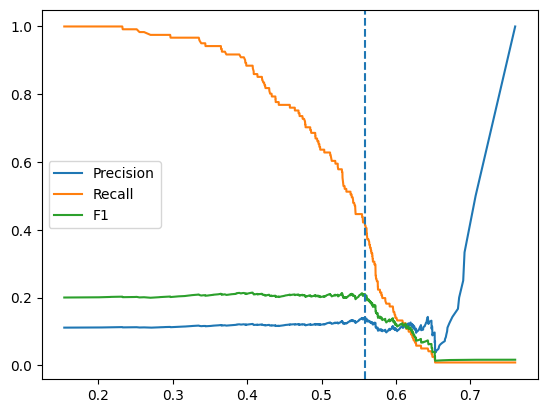

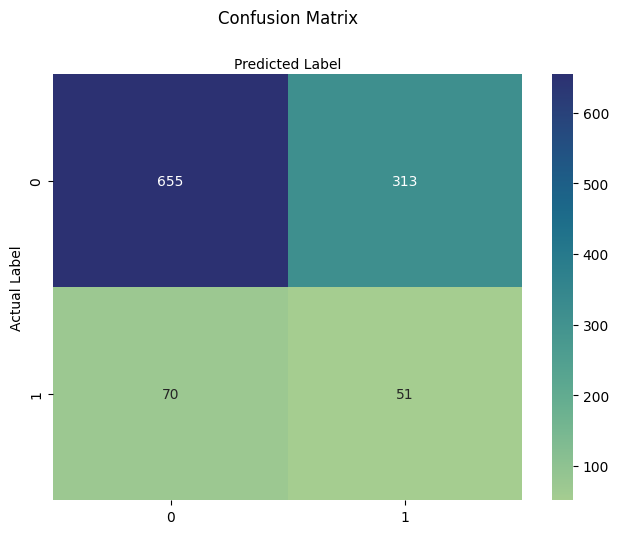

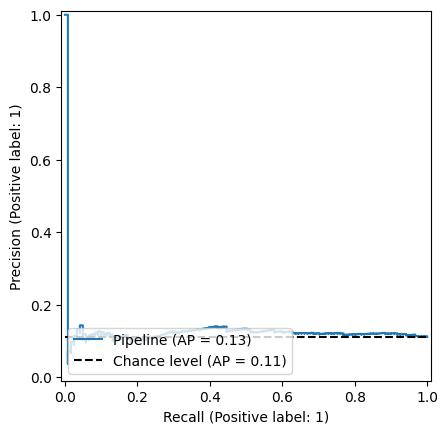

In [28]:
plt.plot(thresholds, precision_N) 
plt.plot(thresholds, recall_N)
plt.plot(thresholds, f1_scores)
plt.axvline(best_threshold, ls='--')
plt.legend(['Precision','Recall','F1'])  

y_predict = best_lr_pipe.predict_proba(x_val_lr)[:,1]
y_predict_custom = (y_predict >= best_threshold).astype(int)


#Evaluating Model through Confusion Matrix
c_matrix = metrics.confusion_matrix(y_val_lr, y_predict_custom)
print(c_matrix)

#Heatmap of Confusion Matrix
classes = [0,1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks = (ticks, classes)
plt.yticks = (ticks, classes)
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='.5g', cmap='crest')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

#Classification Report
targetNames = ['No Performance Dip', 'Performance Dip']
print(classification_report(y_val_lr, y_predict_custom,target_names=targetNames))

#Precision Recall Curve
display = PrecisionRecallDisplay.from_estimator(best_lr_pipe, x_val_lr, y_val_lr, plot_chance_level=True)

support_mask = best_lr_pipe.named_steps['rfe'].get_support()
selectedFeatures = x_train_lr.columns[support_mask]

print("Selected Features by Recursive Feature Elimination: ")
print(list(selectedFeatures))


#Computing Feature Importance
rfe_step = best_lr_pipe.named_steps['rfe']
support_mask = best_lr_pipe.named_steps['rfe'].get_support()
selectedFeatures = x_train_lr.columns[support_mask]
lr_est = rfe_step.estimator_
coefficients = lr_est.coef_.ravel()
oddsRatio = np.exp(coefficients)
pd.set_option('display.max_rows', 500)
featureImportance = pd.DataFrame({
    'Feature': selectedFeatures,
    'Coefficient': coefficients,
    'Odd_Ratio':  oddsRatio
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(featureImportance.sort_values(by='Coefficient', ascending=False))

#Visualization of Feature Importance
fig = px.bar(featureImportance, x='Coefficient', y='Feature', width=1000, height=800)
fig.update_yaxes(tickfont=dict(size=12))
fig.show()



### Random Forest Model

The Random Forest model is the second machine learning model chosen to identify any non-linear patterns to help classify whether player experiences a performance dip.  This model utilizes a multitude of decision trees to make predictions <br>

Similar to logistic regression model earlier, a pipeline containing pre-processing steps for this model is implemented.  Synthetic Minority Over-sampling technique (SMOTE) is integrated because it addresses class imbalance by generating new minority samples through interpolation of existing feature vectors.  SciKit Leearn's n_jobs gets implemented as well to allow parallel processing for more efficient usage.  Conversely to logistic regression model earlier, RandomizedSearch cross validation is incorporated to identify the best hyperparameters to use for the Random Forest model. Because the dataset carries a weak signal and Random Forest invovles many hyperparameters, exploratory search is used to identify optimized values.  <br>

Within the parameter grid, the following hyperparameters get specified:<br>
n_estimators - specifies number of trees used within model<br>
class weight - option to either balance target class weight or have no impact<br>
min_sample_split - least amount of required of observation in any node to allow a split<br>
min_sample_leaf - minimum amount of samples that should be found in leaf node after splitting<br>
max_depth - maximum amount of distance fro root node and leaf node<br>
max_features - number of reatures to consider when looking for best split <br>

The best Random Forest pipeline from RandomizedSearch cross validation technique is loaded in order to predict probabilities for the validation set.  This allows for direct comparison of this model's learnings from training dataset with direct application onto the validation dataset.  Column corresponding to positive target class (PerformanceDip=1) is explicitly stated <br>

One scoring metric of the Random Forest model's performance is precision recall curve, where model's accuracy for positive predictions is directly compared against the amount of positive detections that turn out to be accurate.  This tradeoff is crucial depending on what the overall goal is for prediction.  In this project's context, precision is far more important.  Strong class imbalance already exists where most players do not have a performance dip on a given week. Therefore, accuracy of classified performance dips is crucial and large number of false positives will hinder classifications.  The F1 score is computed as the harmonic mean of precision and recall scores <br>

Recall Floor is established at 0.15 for threshold selection to guarantee baseline of 15% while optimzing for best F1 score in range.  Since large class imbalance exists, the algorithm can theoretically always choose 'No Performance Dip' to increase precision score but diminish recall value.  This customizable tuning allows a specified minimum for recall within a precision recall tradeoff of model performance.

References:
- [Random Forest Classifier ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [Random Forest Classifier Hyperparameters](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)


In [26]:
#Making the x/y splits, dropping player (ID) column + Year that no longer serves a purpose for modeling

rf = RandomForestClassifier()
tscv = TimeSeriesSplit(n_splits=5)
rf_pipe = Pipeline([
    ('smote', SMOTE()),
     ('clf', RandomForestClassifier(
        n_jobs=-1,
        random_state=42
    ))
])

#Parameter Grid to tune the hyperparameters
parameterGrid = [
    {'clf__n_estimators': randint(500, 15000),
     'clf__class_weight': ['balanced', None],
     'clf__min_samples_split': randint(2, 25),
     'clf__min_samples_leaf': randint(1, 100),
     'clf__max_depth': [None] + list(range(10, 50)),
     'clf__max_features': [None, 'sqrt', 'log2']}
]
RandomForest_rsearch = RandomizedSearchCV(rf_pipe, parameterGrid, scoring=['average_precision', 'roc_auc', 'f1', 'accuracy' ],
                                refit='average_precision', return_train_score=True,
                                cv=tscv, n_jobs=-1, verbose=10)
RandomForest_rsearch.fit(x_train_rf, y_train_rf)
print(f"Best hyperparameters for Random Forest Model: {RandomForest_rsearch.best_params_}")
print(f"Best Average Precision Score Through Cross Validation: {RandomForest_rsearch.best_score_}")

#Evaluating precision of model
y_perm = np.random.permutation(y_train_rf)
scores = cross_val_score(rf_pipe, x_train_rf, y_perm, cv=tscv, scoring='average_precision')
print("Mean AP (permuted labels):", scores.mean())

#Using best Random Forest pipeline from Cross Validation Search
best_rf_pipe = RandomForest_rsearch.best_estimator_

#Class probabilities for RandomForest Model
proba = best_rf_pipe.predict_proba(x_val_rf)

#Selecting PerformanceDip Positive Class Column
pos_idx = list(best_rf_pipe.classes_).index(1)
y_proba_rf = proba[:, pos_idx]

#Defining scoring metrics
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_val_rf, y_proba_rf)
#Dropping last point to correctly align shapes
precision_rf_N = precision_rf[:-1]
recall_rf_N = recall_rf[:-1]
#F1 Score Calculation
f1_rf = 2 * (precision_rf_N * recall_rf_N) / (precision_rf_N + recall_rf_N + 1e-6)

#Establishing minimum recall
recallFloor = 0.15
mask = recall_rf_N >= recallFloor
masked_f1 = f1_rf[mask]

#Identifying best classification threshold of model based upon highest F1 score
best_index_mask = np.argmax(masked_f1)
best_index_RF = np.arange(len(f1_rf))[mask][best_index_mask]
best_threshold_rf = thresholds_rf[best_index_RF]
best_precision_rf = precision_rf_N[best_index_RF]
best_recall_rf = recall_rf_N[best_index_RF]
best_f1_rf = f1_rf[best_index_RF]


print({
    "best_threshold_rf": best_threshold_rf,
    "best_precision_rf": best_precision_rf,
    "best_recall_rf":    best_recall_rf,
    "best_f1_rf":        best_f1_rf
})

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Random Forest Model: {'clf__class_weight': 'balanced', 'clf__max_depth': 34, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 64, 'clf__min_samples_split': 14, 'clf__n_estimators': 11134}
Best Average Precision Score Through Cross Validation: 0.16669399958130587
Mean AP (permuted labels): 0.13110324957575173
{'best_threshold_rf': np.float64(0.24420847490672148), 'best_precision_rf': np.float64(0.12742718446601942), 'best_recall_rf': np.float64(0.8677685950413223), 'best_f1_rf': np.float64(0.22222199892746605)}
